<a href="https://colab.research.google.com/github/MMRES-PyBootcamp/MMRES-python-bootcamp2024/blob/master/06_Plotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 12 - TODO (50')
> TODO An introduction to *data visualization* with Seaborn in a purely hands-on approach. Here we will learn how to get beautiful plots using "real life data". In particular, we will try to reproduce some plots appearing in a [Nature paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7960507/).

## Outline
 * [Loading a dataset](#Loading-a-dataset)
 * [Variance and covariance](#Variance-and-covariance)
 * [The covariance matrix](#The-covariance-matrix)
 * [The essence behind of the covariance matrix](#The-essence-behind-of-the-covariance-matrix)
   * [Standardizing the covariance matrix](#Standardizing-the-covariance-matrix)
   * [Eigenthings of the covariance matrix](#Eigenthings-of-the-covariance-matrix)
   * [The meaning of the covariance matrix](#The-meaning-of-the-covariance-matrix)
 * [Principal component analysis](#Principal-component-analysis)

This document is devised as a tool to enable your **self-learning process**. If you get stuck at some step or need any kind of help, please don't hesitate to raise your hand and ask for the teacher's guidance. Along it, you will find some **special cells**:

<div class="alert alert-block alert-success"><b>Practice:</b> Practice cells announce exercises that you should try during the current boot camp session. Usually, solutions are provided using hidden cells (look for the dot dot dot symbol "..." and click to unravel them and check that your try is correct).
</div>

<div class="alert alert-block alert-warning"><b>Extension:</b> Extension cells correspond to exercises (or links to contents) that are a bit more advanced. We recommend to try them after the current boot camp session.
</div>

<div class="alert alert-block alert-info"><b>Tip:</b> Tip cells just give some advice or complementary information.
</div>

<div class="alert alert-block alert-danger"><b>Caveat:</b> Caveat cells warn you about the most common pitfalls one founds when starts his/her path learning Python.

</div>

---

In [1]:
# Load packages with their corresponding alias
import numpy as np
import pandas as pd
import plotnine as p9
import seaborn as sns

import matplotlib.pyplot as plt

## Loading a dataset

Let's stats by loading again the IQ dataset [online resource](https://lectures.scientific-python.org/packages/statistics/index.html).

In [2]:
# Loading the "Brain Size" dataset directly from an URL
df = pd.read_csv(
    filepath_or_buffer='https://scipy-lectures.org/_downloads/brain_size.csv',
    sep=';',
    na_values=".",
    index_col=0
)

# Show df's head
df.head()

,Gender,FSIQ,VIQ,PIQ,Weight,Height,MRI_Count
1,Female,133,132,124,118.0,64.5,816932
2,Male,140,150,124,NaN,72.5,1001121
3,Male,139,123,150,143.0,73.3,1038437
4,Male,133,129,128,172.0,68.8,965353
5,Female,137,132,134,147.0,65.0,951545


Remeber that the columns *FSIQ*, *VIQ* and *PIQ* stand for different "intelligence quotients" and the *MRI_Count* is another "intelligence" measure based on magnetic resonance imaging. The columns *Gender*, *Weight* and *Height* express the gender, the weight (in pounds) and the height (in inches) of the individuals, respectively. As usual, let's express *Weight* and *Height* column values to metric units before starting.

In [3]:
# Convert from imperial units to metric units
df['Weight [kg]'] = df['Weight'] * 0.45359237
df['Height [m]'] = df['Height'] * 0.0254

# Drop imperial columns
df.drop(columns=['Weight', 'Height'], inplace=True)

# Show df's head
df.head()

,Gender,FSIQ,VIQ,PIQ,MRI_Count,Weight [kg],Height [m]
1,Female,133,132,124,816932,53.523900,1.63830
2,Male,140,150,124,1001121,NaN,1.84150
3,Male,139,123,150,1038437,64.863709,1.86182
4,Male,133,129,128,965353,78.017888,1.74752
5,Female,137,132,134,951545,66.678078,1.65100


## Variance and covariance

Suppose that we have random variable $x = \left( x_i, \dots, x_n \right)$, then, its *variance* is defined as the *expected value of the squared deviation between $x$ and its expected value $E[x]$*:

\begin{equation}
\sigma^2_x = E \left[ \left( x - E \left[ x \right] \right)^2  \right],
\end{equation}

which in the particular case of a discrete equally likely random variable becomes: 

\begin{equation}
\sigma^2_x = \frac{1}{N} \sum_{i=1}^n{\left( x_i - \mu_x \right)^2}
\end{equation}.

Let's try to implement this last $\sigma^2_{x}$ expression using *NumPy*:

In [4]:
# Initiate a "seeded" random number generator
rnd_seed = np.random.default_rng(seed=1985)

# Generate a random x variable following a uniform distribution
x = rnd_seed.uniform(low=-1, high=+1, size=15)

# Compute the variance of x by hand
sigma2_x = (1 / len(x)) * sum( (x - x.mean())**2 )

# Show the result
print(sigma2_x)

0.31250739363824304


Before continuing, let's quickly check if our variance implementation is correct:

In [5]:
# Compute the variance of x with NumPy and show it
np.var(x)

np.float64(0.3125073936382431)

So far so good, now let's move on! The *covariance* of two random variables $x = \left( x_i, \dots, x_n \right)$ and $y = \left( y_i, \dots, y_n \right)$ is defined as the *expected value of the product of the deviations between those variables ($x$ and $y$) and their corresponding expected values ($E[x]$ and $E[y]$)*:

\begin{equation}
\sigma^2_{xy} = E \left[ \sigma^2_x \sigma^2_y \right] = E \left[ \left( x - E \left[ x \right] \right) \left( y - E \left[ y \right] \right) \right],
\end{equation}


which in the particular case of a discrete equally likely random variable becomes: 

\begin{equation}
\sigma^2_{xy} = \frac{1}{N} \sum_{i=1}^n{\left( x_i - \mu_x \right) \left( y_i - \mu_y \right)}
\end{equation}.

As we just did for $\sigma^2_{x}$, let's try to implement the $\sigma^2_{xy}$ expression using **NumPy**:

In [6]:
# Initiate a "seeded" random number generator
rnd_seed = np.random.default_rng(seed=1985)

# Generate random x and y variables following a uniform distribution
x = rnd_seed.uniform(low=-1, high=+1, size=15)
y = rnd_seed.uniform(low=-1, high=+1, size=15)

# Compute the covariance between x and y by hand
sigma2_xy = (1 / len(x)) * sum( (x - x.mean()) * (y - y.mean()) )
print(sigma2_xy)

-0.08878353818004929


And, again, let's quickly check our result:

In [7]:
# Compute the covariance between x and y with NumPy and show it
np.cov(x, y, bias=True)

array([[ 0.31250739, -0.08878354],
       [-0.08878354,  0.25061591]])

## The covariance matrix

Note that when we asked **NumPy** to compute the covariance between $x$ and $y$, we got a $2 \times 2$ symmetric matrix. The off-diagonal elements in this matrix are the covariance between $x$ and $y$ ($\sigma^2_{xy}$) and the covariance between $y$ and $x$ ($\sigma^2_{yx}$), which, as expected, gave identical estimates. Analogously, the diagonal elements in this matrix are the covariance of $x$ with itself ($\sigma^2_{xx}$, AKA the variance of $x$, $\sigma^2_{x}$) and the covariance of $y$ with itself ($\sigma^2_{yy}$, AKA the variance of $y$, $\sigma^2_{y}$):

\begin{equation}
 \begin{pmatrix}
 0.3125 & -0.0888 \\
-0.0888 & 0.2506
\end{pmatrix} = \begin{pmatrix}
 \sigma^2_{xx} & \sigma^2_{xy} \\
\sigma^2_{yx} & \sigma^2_{yy}
\end{pmatrix} = \begin{pmatrix}
 \sigma^2_{x} & \sigma^2_{xy} \\
\sigma^2_{yx} & \sigma^2_{y}
\end{pmatrix}
\end{equation}

Let's check this out:

In [8]:
# Compute the covariance between x and y by hand (sigma2_xx)
sigma2_xx = (1 / len(x)) * sum( (x - x.mean()) * (x - x.mean()) )

# Compute the covariance between x and y by hand (sigma2_xy)
sigma2_xy = (1 / len(x)) * sum( (x - x.mean()) * (y - y.mean()) )

# Compute the covariance between x and y by hand (sigma2_yx)
sigma2_yx = (1 / len(y)) * sum( (y - y.mean()) * (x - x.mean()) )

# Compute the covariance between x and y by hand (sigma2_yy)
sigma2_yy = (1 / len(y)) * sum( (y - y.mean()) * (y - y.mean()) )

# Arrange the sigma2_xx, sigma2_xy, sigma2_yx and sigma2_yy as a 2x2 matrix
np.array([ [sigma2_xx, sigma2_xy], [sigma2_yx, sigma2_yy] ])

array([[ 0.31250739, -0.08878354],
       [-0.08878354,  0.25061591]])

This is the *covariance matrix* of the variables $x$ and $y$. Try to imagine how it would be, for example, the covariance matrix between three variables $x$, $y$ and $z$ (an so on for and arbitrary number of variables).

<div class="alert alert-block alert-success">
    
<b>Practice 1:</b> Get the **covariance matrix** between the variables **height** and **weight** in the IQ dataset.

1) In the 1<sup>st</sup> code cell below, use the <b>NumPy</b> function `np.cov()` to compute the *covariance matrix* between the variables `Height [m]` and `Weight [kg]` in `df`. What happened in this first try?
2) In the 2<sup>nd</sup> code cell below, use the <b>NumPy</b> function `np.cov()` to compute the *covariance matrix* between the variables `Height [m]` and `Weight [kg]` in `df_DropNan`. What happened in this second try?

<b>Note:</b> Uncomment and fill only those code lines with underscores `___`.

</div>

In [9]:
# (1st code cell)

# Compute the covariance between Height [m] and Weight [kg] with NumPy and show it
#print(___(___, ___, bias=True))

# Show df's head
#df.head()

In [10]:
# (1st code cell)

# Compute the covariance between Height [m] and Weight [kg] with NumPy and show it
print(np.cov(df['Height [m]'], df['Weight [kg]'], bias=True))

# Show df's head
df.head()

[[nan nan]
 [nan nan]]


,Gender,FSIQ,VIQ,PIQ,MRI_Count,Weight [kg],Height [m]
1,Female,133,132,124,816932,53.523900,1.63830
2,Male,140,150,124,1001121,NaN,1.84150
3,Male,139,123,150,1038437,64.863709,1.86182
4,Male,133,129,128,965353,78.017888,1.74752
5,Female,137,132,134,951545,66.678078,1.65100


In [11]:
# (2nd code cell)

# Dropping all rows with NANs to enable covariance computation
df_DropNan = df.dropna().copy()

# Compute the covariance between Height [m] and Weight [kg] with NumPy and show it
#print(___(___, ___, bias=True))

# Show df_DropNan's head
#df_DropNan.head()

In [12]:
# (2nd code cell)

# Dropping all rows with NANs to enable covariance computation
df_DropNan = df.dropna().copy()

# Compute the covariance between Height [m] and Weight [kg] with NumPy and show it
print(np.cov(df_DropNan['Height [m]'], df_DropNan['Weight [kg]'], bias=True))

# Show df_DropNan's head
df_DropNan.head()

[[1.00197280e-02 7.35921995e-01]
 [7.35921995e-01 1.10430909e+02]]


,Gender,FSIQ,VIQ,PIQ,MRI_Count,Weight [kg],Height [m]
1,Female,133,132,124,816932,53.523900,1.63830
3,Male,139,123,150,1038437,64.863709,1.86182
4,Male,133,129,128,965353,78.017888,1.74752
5,Female,137,132,134,951545,66.678078,1.65100
6,Female,99,90,110,928799,66.224486,1.75260


<div class="alert alert-block alert-success"><b>Practice 1 ends here.</b>

</div>

## The essence behind of the covariance matrix

### Standardizing the covariance matrix

Now, we will use the particular example of the covariance between `Height [m]` and `Weight [kg]` to get an intuitive understanding of this covariance matrix. As usual, let's start by visualizing the data:

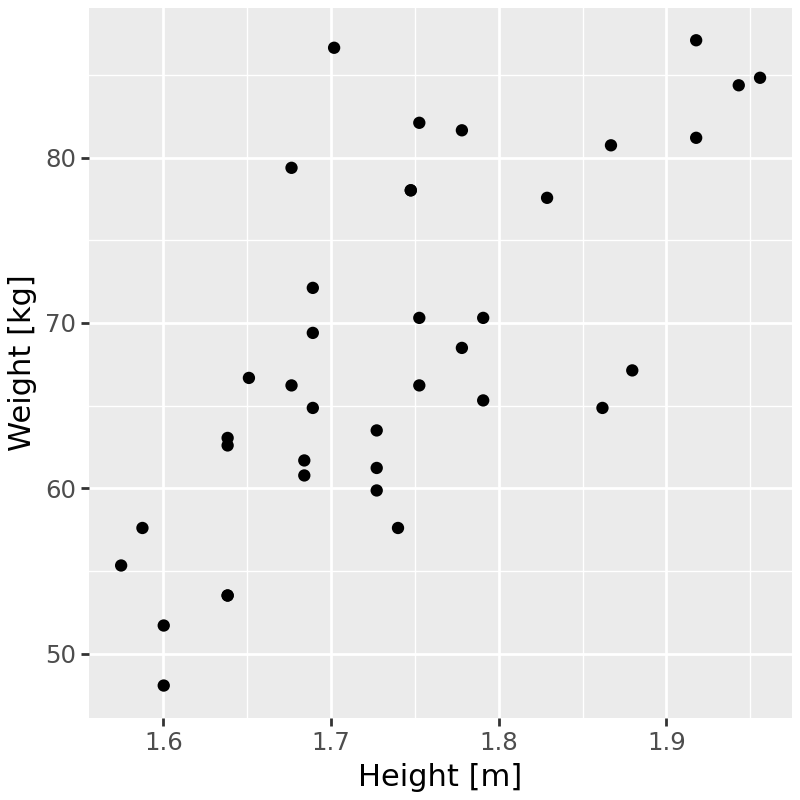

In [13]:
# Create the scatter plot with Plotnine (metric data)
gg = (
    p9.ggplot(data=df_DropNan, mapping=p9.aes(x='Height [m]', y='Weight [kg]'))
    + p9.geom_point()
    + p9.theme(figure_size=(4, 4))
)

# Show plot
gg

In order to simplify a bit some of the steps downstream, let's standardize this data:

In [14]:
# Get the z-score for 'Height [m]' and 'Weight [kg]'
df_DropNan['Z-Height'] = (df_DropNan['Height [m]'] - np.mean(df_DropNan['Height [m]'])) / np.std(df_DropNan['Height [m]'])
df_DropNan['Z-Weight'] = (df_DropNan['Weight [kg]'] - np.mean(df_DropNan['Weight [kg]'])) / np.std(df_DropNan['Weight [kg]'])

# Show df_DropNan's head
df_DropNan.head()

,Gender,FSIQ,VIQ,PIQ,MRI_Count,Weight [kg],Height [m],Z-Height,Z-Weight
1,Female,133,132,124,816932,53.523900,1.63830,-0.994966,-1.426680
3,Male,139,123,150,1038437,64.863709,1.86182,1.238032,-0.347583
4,Male,133,129,128,965353,78.017888,1.74752,0.096158,0.904170
5,Female,137,132,134,951545,66.678078,1.65100,-0.868092,-0.174927
6,Female,99,90,110,928799,66.224486,1.75260,0.146908,-0.218091


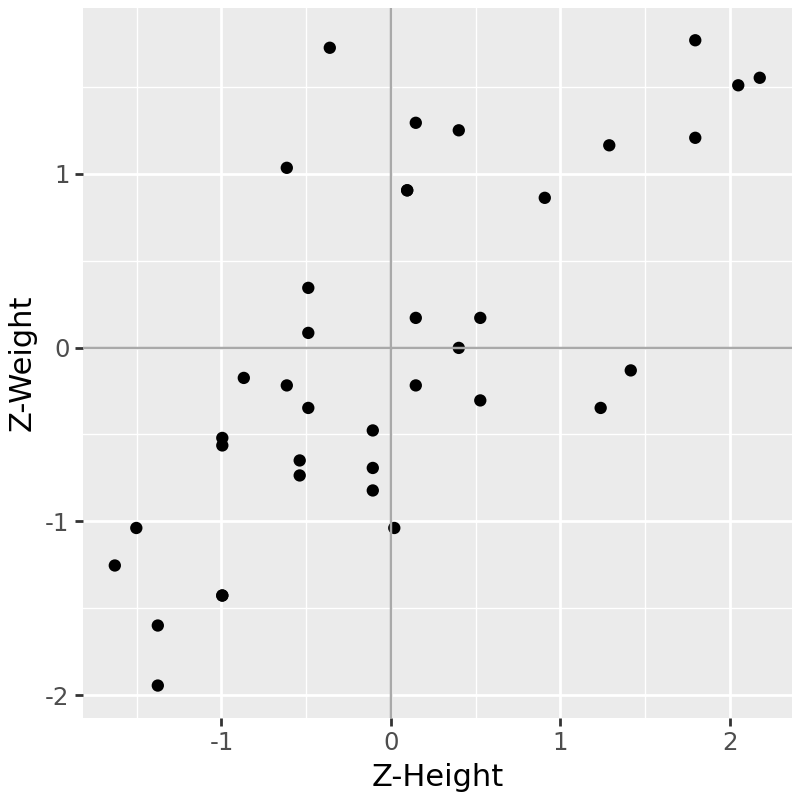

In [15]:
# Create the scatter plot with Plotnine (z-score data)
gg = (
    p9.ggplot(data=df_DropNan, mapping=p9.aes(x='Z-Height', y='Z-Weight'))
    + p9.geom_point()
    + p9.theme(figure_size=(4, 4))
    + p9.geom_vline(xintercept=0, color='darkgrey')
    + p9.geom_hline(yintercept=0, color='darkgrey')
)

# Show plot
gg

Note that both scatter plots are identical, with the unique difference being the scale of both axes. Now, let's compute the covariance matrix for the z-score data we just generated.

In [16]:
# Compute the covariance between 'Z-Height' and 'Z-Weight' with NumPy and show it
Sigma_Z = np.cov(df_DropNan['Z-Height'], df_DropNan['Z-Weight'], bias=True)

# Show the covariance matrix
Sigma_Z

array([[1.      , 0.699614],
       [0.699614, 1.      ]])

Note how the *covariance matrix* of the z-score data has *ones* in the diagonal in contrast to its non z-scored counterpart:

In [17]:
# Compute the covariance between 'Height' and 'Weight' with NumPy and show it
Sigma = np.cov(df_DropNan['Height [m]'], df_DropNan['Weight [kg]'], bias=True)

# Show the covariance matrix
Sigma

array([[1.00197280e-02, 7.35921995e-01],
       [7.35921995e-01, 1.10430909e+02]])

This is something natural because, when we z-scored the data, we manually bring the distribution of values to a standardized distribution with variance 1 and mean 0.

### Eigenthings of the covariance matrix

Now, if we look at the covariance matrix through the prism of *Linear Algebra*, we could understand this $2 \times 2$ matrix as a *linear transformation in a two-dimensional space*... Remember that *linear transformation* ($\textbf{M}$) is just something that "transmutes" an input vector ($\vec{v}$) to an output vector ($\vec{u}$). Let's see an example:

In [18]:
# Initiate a "seeded" random number generator
rnd_seed = np.random.default_rng(seed=1985)

# Create a random vector "v" (2 x 1)
v = rnd_seed.integers(low=-5, high=5, size=2)

# Create a random lineal transformation "M" (2 x 2)
M = rnd_seed.integers(low=-5, high=5, size=(2, 2))

# Apply "M" to "v" and store the output vector "u" (2 x 1)
u = M @ v

# Print "v", "M" and "u"
print(f'v = {v}', f'M = {M}', f'u = {u}', sep='\n\n')

v = [-2 -3]

M = [[-4 -1]
 [-1  0]]

u = [11  2]


\begin{equation}
\textbf{M} \vec{v} = \begin{pmatrix}  -4 & -1 \\ -1 & 0 \end{pmatrix} \cdot \begin{pmatrix} -2 \\ -3 \end{pmatrix} = \begin{pmatrix} (-4) \cdot (-2) + (-1) \cdot (-3) \\ (-1) \cdot (-2) + 0 \cdot (-3) \end{pmatrix} = \begin{pmatrix} 8 + 3 \\ 2 + 0 \end{pmatrix} = \begin{pmatrix} 11 \\ 2  \end{pmatrix} = \vec{u}
\end{equation}

These "transmutations" cannot be arbitrary as they have to preserve certain vector operations (vector additivity and vector scalar multiplication). Intuitively, after passing through a linear transformation, the original direction of $\vec{v}$ can be (but no necessarily) *rotated* and the original length of $\vec{v}$ can be (but no necessarily) *elongated* or *shortened*:

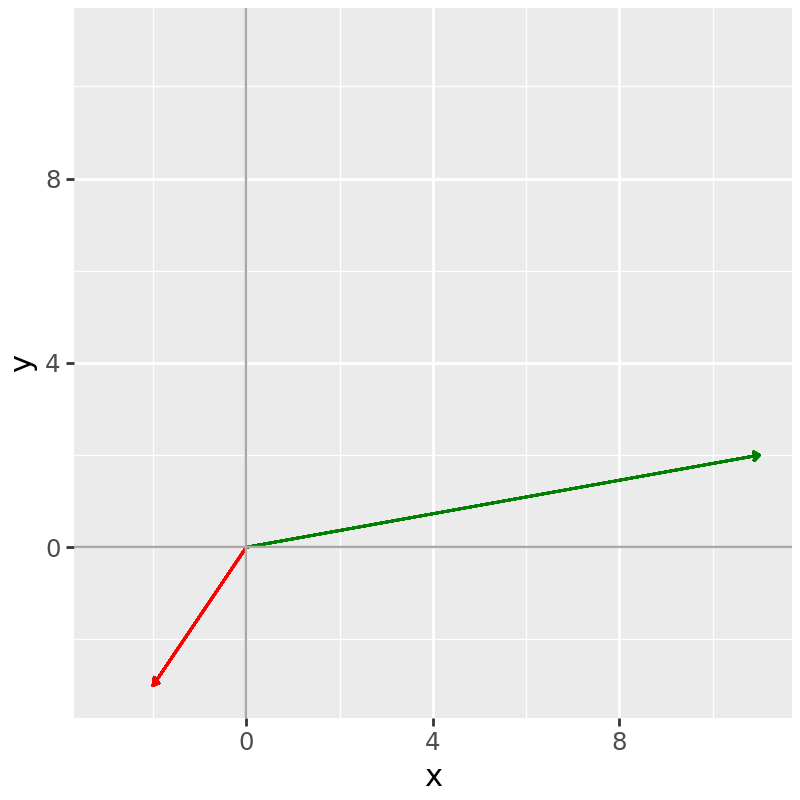

In [19]:
# Plot input "v" (red) and output "u" (green) vectors
gg = (
    p9.ggplot(data=df)
    + p9.geom_segment(
        x=0, y=0,
        xend=v[0], yend=v[1],
        color='red',
        arrow=p9.arrow(angle=30, length=0.05, ends="last", type="closed")
     )
    + p9.geom_segment(
        x=0, y=0,
        xend=u[0], yend=u[1],
        color='green',
        arrow=p9.arrow(angle=30, length=0.05, ends="last", type="closed")
     )
    + p9.geom_vline(xintercept=0, color='darkgrey')
    + p9.geom_hline(yintercept=0, color='darkgrey')
    + p9.xlim(-3, 11) + p9.ylim(-3, 11) + p9.xlab('x') + p9.ylab('y')
    + p9.theme(figure_size=(4, 4))
)

# Show plot
gg

Linear transformations present certain special directions (two in the particular case of two-dimensional linear transformations). All the vectors living in these special directions will keep their directions unchanged after passing through the linear transformation. In other words, these vectors can be *elongated* or *shortened* but never *rotated* when passing through the linear transformation. This is precisely the definition of *eigenvector*: a vector $\vec{v}$ that is proportional to itself, $\lambda \vec{v}$, after passing through the linear transformation $\textbf{M}$:

\begin{equation}
\textbf{M} \vec{v} = \vec{u} = \lambda \vec{v},
\end{equation}

where this proportional constant $\lambda$ is the *eigenvalue* associated to the eigenvector $\vec{v}$. Let's get the eigenvectors and eigenvalues of $\textbf{M}$ leveraging the **NumPy** function [`np.linalg.eig()`](https://numpy.org/doc/2.3/reference/generated/numpy.linalg.eig.html):

In [20]:
# Get the eigenvectors and eigenvalues of M
eigenthings = np.linalg.eig(M)

# Print the eigenvectors and eigenvalues of M
print(eigenthings)

EigResult(eigenvalues=array([-4.23606798,  0.23606798]), eigenvectors=array([[-0.97324899,  0.22975292],
       [-0.22975292, -0.97324899]]))


<div class="alert alert-block alert-danger">

<b>Caveat:</b> Keep in mind that `np.linalg.eig()` return the eigenvectors in a matrix <b><u>as columns</u></b>, (not as rows!):

\begin{equation}
 \begin{pmatrix} \vec{v}_1 & \vec{v}_2 \end{pmatrix} =
 \begin{pmatrix} \begin{pmatrix} v_{11} \\ v_{21} \end{pmatrix} & \begin{pmatrix} v_{12} \\ v_{22} \end{pmatrix} \end{pmatrix} =
  \begin{pmatrix} \begin{pmatrix} -0.9732 \\ -0.2298 \end{pmatrix} & \begin{pmatrix} 0.2298 \\ -0.9732 \end{pmatrix} \end{pmatrix} =
 \begin{pmatrix} -0.9732 & 0.2298 \\ -0.2298 & -0.9732 \end{pmatrix}
 \Rightarrow  \begin{cases}
      \vec{v}_1 = \begin{pmatrix} -0.9732 \\ -0.2298 \end{pmatrix} \\
      \\
      \vec{v}_2 = \begin{pmatrix} 0.2298 \\ -0.9732 \end{pmatrix} \\
    \end{cases} 
\end{equation}

</div>

In [21]:
# Store the first (0) and the second (1) eigenvectors
e0 = eigenthings.eigenvectors[:, 0]
e1 = eigenthings.eigenvectors[:, 1]
print('Eigenvectors:', e0, e1, '', sep='\n')

# Store the first (0) and the second (1) eigenvalues
λ0 = eigenthings.eigenvalues[0]
λ1 = eigenthings.eigenvalues[1]
print('Eigenvalues:', λ0, λ1, '', sep='\n')

# Apply "M" to the first (0) and the second (1) eigenvectors and store them
Me0 = M @ e0
Me1 = M @ e1
print('M applied to the eigenvectors:', Me0, Me1, '', sep='\n')

# Multiply each eigenvector by its eigenvalue
λ0e0 = λ0 * e0
λ1e1 = λ1 * e1
print('Eigenvalues multiplied by the eigenvectors:', λ0e0, λ1e1, '', sep='\n')

Eigenvectors:
[-0.97324899 -0.22975292]
[ 0.22975292 -0.97324899]

Eigenvalues:
-4.23606797749979
0.2360679774997897

M applied to the eigenvectors:
[4.12274888 0.97324899]
[ 0.05423731 -0.22975292]

Eigenvalues multiplied by the eigenvectors:
[4.12274888 0.97324899]
[ 0.05423731 -0.22975292]



Note how multiplying the eigenvectors by their corresponding eigenvalues, $\lambda_{i} \vec{e}_i$, returns the vectors resulting when we applying the linear transformation to such eigenvector, $\textbf{M} \vec{e}_i$, because, by construction:

\begin{equation}
\textbf{M} \vec{e}_i = \lambda_{i} \vec{e}_i
\end{equation}

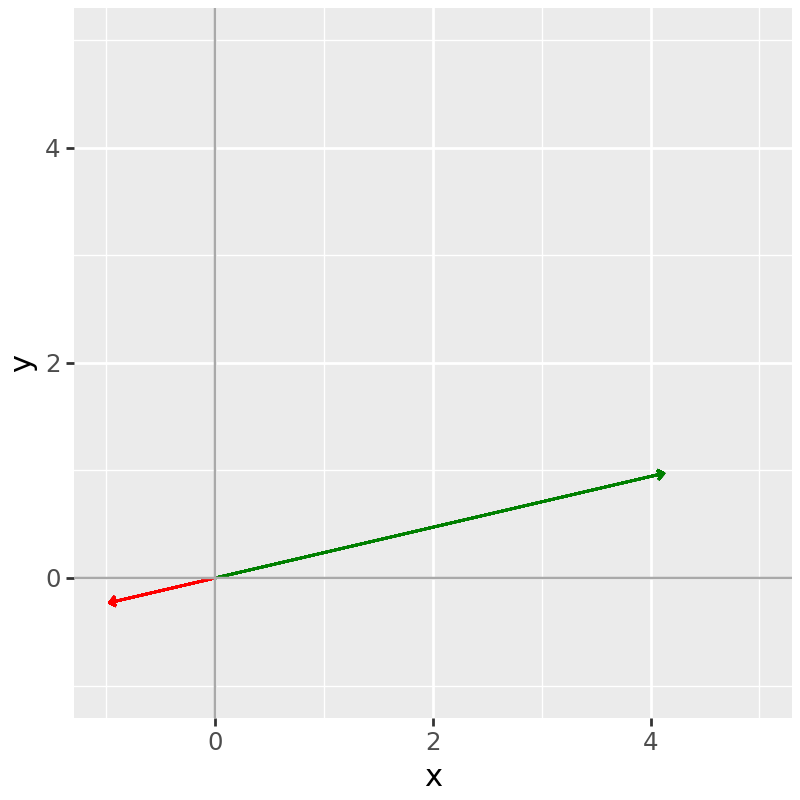

In [22]:
# Plot input "e0" (red) and output "Me0" (green) vectors
gg = (
    p9.ggplot(data=df)
    + p9.geom_segment(
        x=0, y=0,
        xend=e0[0], yend=e0[1],
        color='red',
        arrow=p9.arrow(angle=30, length=0.05, ends="last", type="closed")
     )
    + p9.geom_segment(
        x=0, y=0,
        xend=Me0[0], yend=Me0[1],
        color='green',
        arrow=p9.arrow(angle=30, length=0.05, ends="last", type="closed")
     )
    + p9.geom_vline(xintercept=0, color='darkgrey')
    + p9.geom_hline(yintercept=0, color='darkgrey')
    + p9.xlim(-1, 5) + p9.ylim(-1, 5) + p9.xlab('x') + p9.ylab('y')
    + p9.theme(figure_size=(4, 4))
    
)

# Show plot
gg

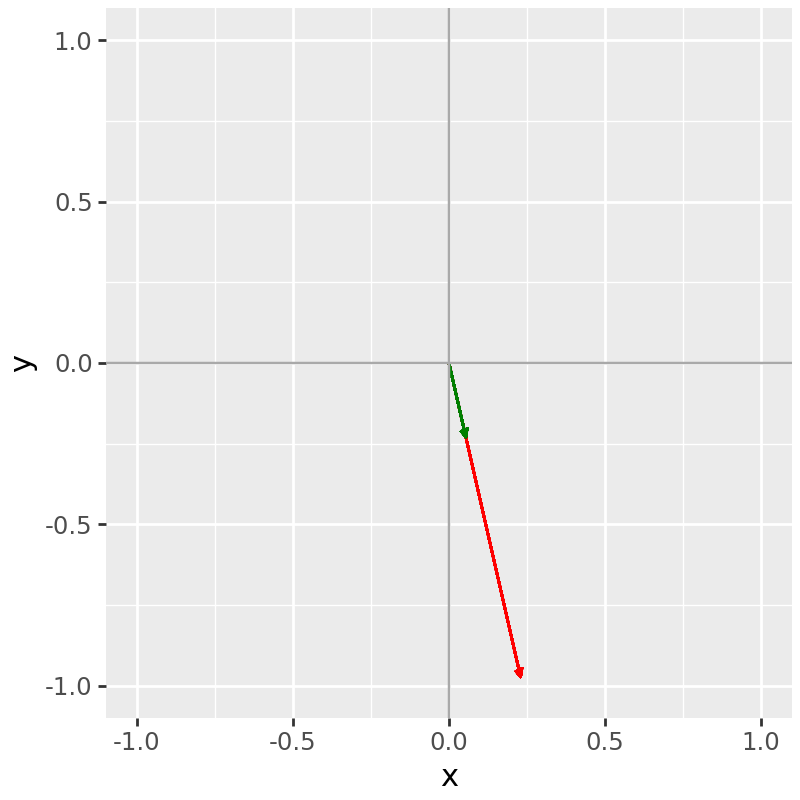

In [23]:
# Plot input "e1" (red) and output "Me1" (green) vectors
gg = (
    
    # Create the scatter plot with Plotnine
    p9.ggplot(data=df)
    + p9.geom_segment(
        x=0, y=0,
        xend=e1[0], yend=e1[1],
        color='red',
        arrow=p9.arrow(angle=30, length=0.05, ends="last", type="closed")
     )
    + p9.geom_segment(
        x=0, y=0,
        xend=Me1[0], yend=Me1[1],
        color='green',
        arrow=p9.arrow(angle=30, length=0.05, ends="last", type="closed")
     )
    + p9.geom_vline(xintercept=0, color='darkgrey')
    + p9.geom_hline(yintercept=0, color='darkgrey')
    + p9.xlim(-1, 1) + p9.ylim(-1, 1) + p9.xlab('x') + p9.ylab('y')
    + p9.theme(figure_size=(4, 4))
)

# Show plot
gg

We see that, after passing through $\textbf{M}$, the first eigenvector $\vec{e}_0$ is *reversed* and *elongated* ($\lambda_0 = -4.236$) whilst the second eigenvector $\vec{e}_1$ is *shortened* ($\lambda_1 = +0.236$), but both of them keep their directions intact. Note how their corresponding eigenvalues encode this outcome.

<div class="alert alert-block alert-success">
    
<b>Practice 2:</b> Get the **eigenvalues** and the **eigenvectors** of the **covariance matrix** that we have already obtained for the **height** and **weight** after z-scoring the data.

1) In the 1<sup>st</sup> code cell below, use the <b>NumPy</b> function `np.linalg.eig()` to compute the the eigenvalues and the eigenvectors of the covariance matrix between the variables `Z-Height` and `Z-Weight` from our `df_DropNan` dataset (`Sigma_Z`).
2) In the 2<sup>nd</sup> code cell below, breakdown the `EigResult` object returned by `np.linalg.eig()` and store both eigenvectors as `e0` and `e1` and both eigenvalues as `λ0` and `λ1`.
3) In the 3<sup>rd</sup> code cell below, represent `e0` and `e1` on the scatter plot with `Z-Weight` versus `Z-Height`. **What do you observe?**
4) In the 4<sup>th</sup> code cell below, represent again `e0` and `e1` on the scatter plot, but scaling each eigenvector by its corresponding eigenvalue. **What do you observe now?**

<b>Note:</b> Uncomment and fill only those code lines with underscores `___`.

</div>

In [25]:
# (1st code cell)

# Show the the z-scored covariance matrix
# print('Covariance matrix:', ___, '', sep='\n')

# Get the eigenvectors and eigenvalues of the z-scored covariance matrix
# eigen = ___(___)

# Print the eigenvectors and eigenvalues of the z-scored covariance matrix
# print('EigResult object:', eigen, '', sep='\n')

In [26]:
# (1st code cell)

# Show the the z-scored covariance matrix
print('Covariance matrix:', Sigma_Z, '', sep='\n')

# Get the eigenvectors and eigenvalues of the z-scored covariance matrix
eigen = np.linalg.eig(Sigma_Z)

# Print the eigenvectors and eigenvalues of the z-scored covariance matrix
print('EigResult object:', eigen, '', sep='\n')

Covariance matrix:
[[1.       0.699614]
 [0.699614 1.      ]]

EigResult object:
EigResult(eigenvalues=array([1.699614, 0.300386]), eigenvectors=array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]]))



In [27]:
# (2nd code cell)

# Store the first (0) and the second (1) eigenvectors and show them
# e0 = eigen.___[___, ___]
# e1 = eigen.___[___, ___]
# print('Eigenvectors:', ___, ___, '', sep='\n')

# Store the first (0) and the second (1) eigenvalues and show them
# λ0 = eigen.___[___]
# λ1 = eigen.___[___]
# print('Eigenvalues:', ___, ___, '', sep='\n')

In [28]:
# (2nd code cell)

# Store the first (0) and the second (1) eigenvectors and show them
e0 = eigen.eigenvectors[:, 0]
e1 = eigen.eigenvectors[:, 1]
print('Eigenvectors:', e0, e1, '', sep='\n')

# Store the first (0) and the second (1) eigenvalues and show them
λ0 = eigen.eigenvalues[0]
λ1 = eigen.eigenvalues[1]
print('Eigenvalues:', λ0, λ1, '', sep='\n')

Eigenvectors:
[0.70710678 0.70710678]
[-0.70710678  0.70710678]

Eigenvalues:
1.699614004238759
0.3003859957612409



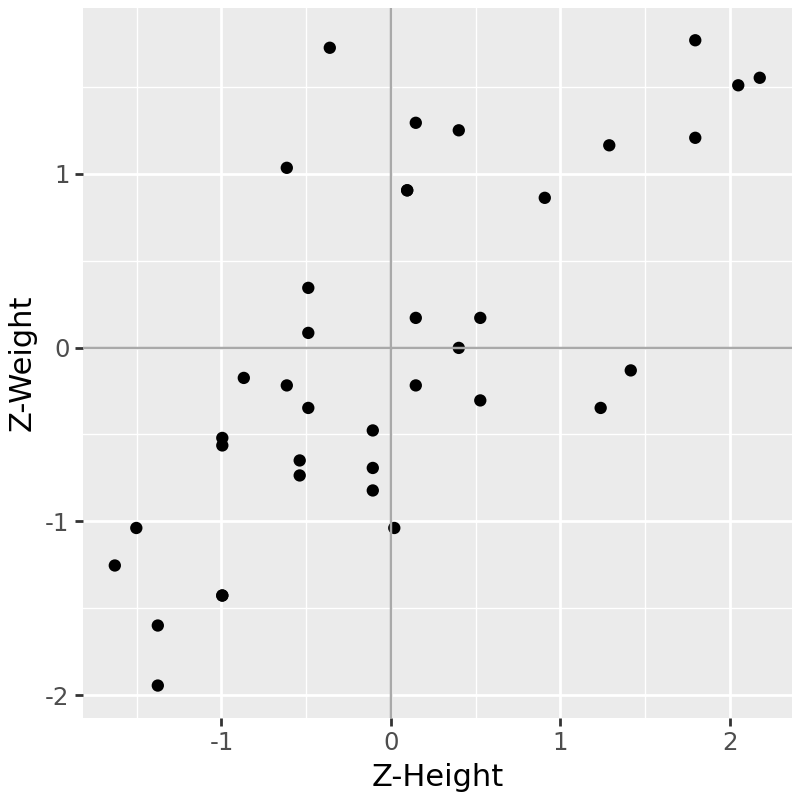

In [29]:
# (3rd code cell)

# Create the scatter plot with Plotnine (z-score data)
gg = (
    p9.ggplot(data=df_DropNan, mapping=p9.aes(x='Z-Height', y='Z-Weight'))
    + p9.geom_point()
    + p9.theme(figure_size=(4, 4))

     # Plot the first eigenvector
#    + p9.geom_segment(
#        x=0, y=0,
#        xend=___, yend=___],
#        color='red',
#        arrow=p9.arrow(angle=30, length=0.05, ends="last", type="closed")
#     )

     # Plot the second eigenvector
#    + p9.geom_segment(
#        x=0, y=0,
#        xend=___, yend=___,
#        color='green',
#        arrow=p9.arrow(angle=30, length=0.05, ends="last", type="closed")
#     )

    + p9.geom_vline(xintercept=0, color='darkgrey')
    + p9.geom_hline(yintercept=0, color='darkgrey')
)

# Show plot
gg

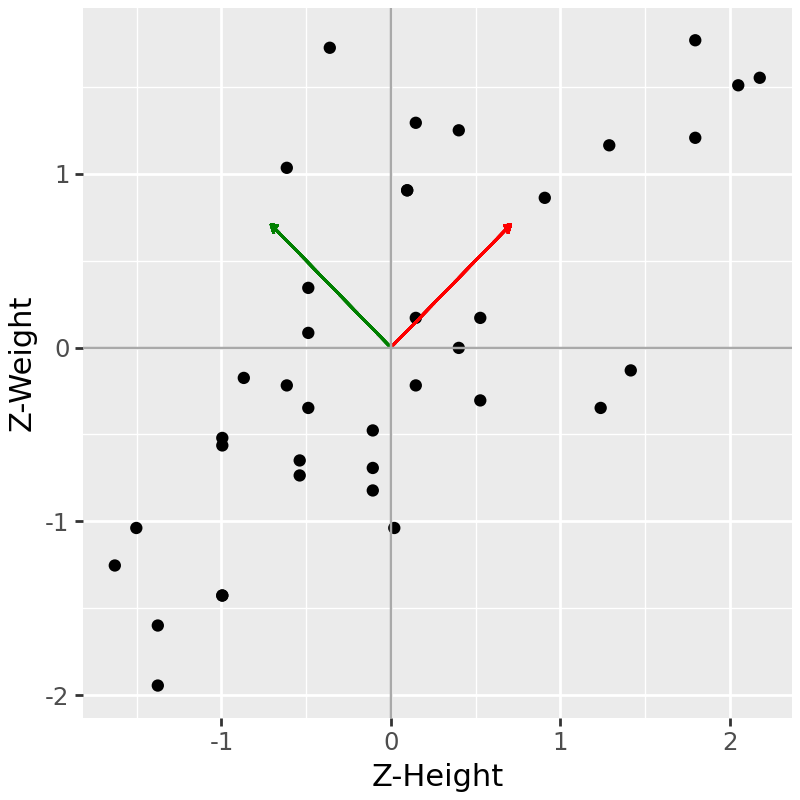

In [30]:
# (3rd code cell)

# Create the scatter plot with Plotnine (z-score data)
gg = (
    p9.ggplot(data=df_DropNan, mapping=p9.aes(x='Z-Height', y='Z-Weight'))
    + p9.geom_point()
    + p9.theme(figure_size=(4, 4))

    # Plot the first eigenvector
    + p9.geom_segment(
        x=0, y=0,
        xend=e0[0], yend=e0[1],
        color='red',
        arrow=p9.arrow(angle=30, length=0.05, ends="last", type="closed")
     )

    # Plot the second eigenvector
    + p9.geom_segment(
        x=0, y=0,
        xend=e1[0], yend=e1[1],
        color='green',
        arrow=p9.arrow(angle=30, length=0.05, ends="last", type="closed")
     )
    + p9.geom_vline(xintercept=0, color='darkgrey')
    + p9.geom_hline(yintercept=0, color='darkgrey')
)

# Show plot
gg

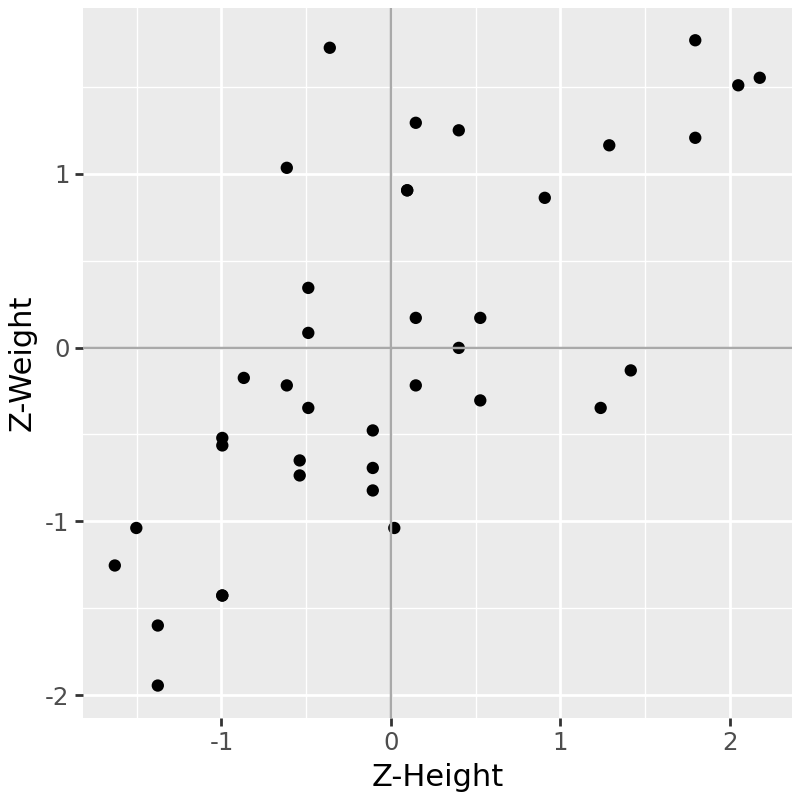

In [32]:
# (4th code cell)

# Create the scatter plot with Plotnine (z-score data)
gg = (
    p9.ggplot(data=df_DropNan, mapping=p9.aes(x='Z-Height', y='Z-Weight'))
    + p9.geom_point()
    + p9.theme(figure_size=(4, 4))

    # Plot the second eigenvector (scaled)
#    + p9.geom_segment(
#        x=0, y=0,
#        xend=___, yend=___,
#        color='red',
#        arrow=p9.arrow(angle=30, length=0.05, ends="last", type="closed")
#     )
#
#    # Plot the second eigenvector (scaled)
#    + p9.geom_segment(
#        x=0, y=0,
#        xend=___, yend=___,
#        color='green',
#        arrow=p9.arrow(angle=30, length=0.05, ends="last", type="closed")
#     )

    + p9.geom_vline(xintercept=0, color='darkgrey')
    + p9.geom_hline(yintercept=0, color='darkgrey')
)

# Show plot
gg

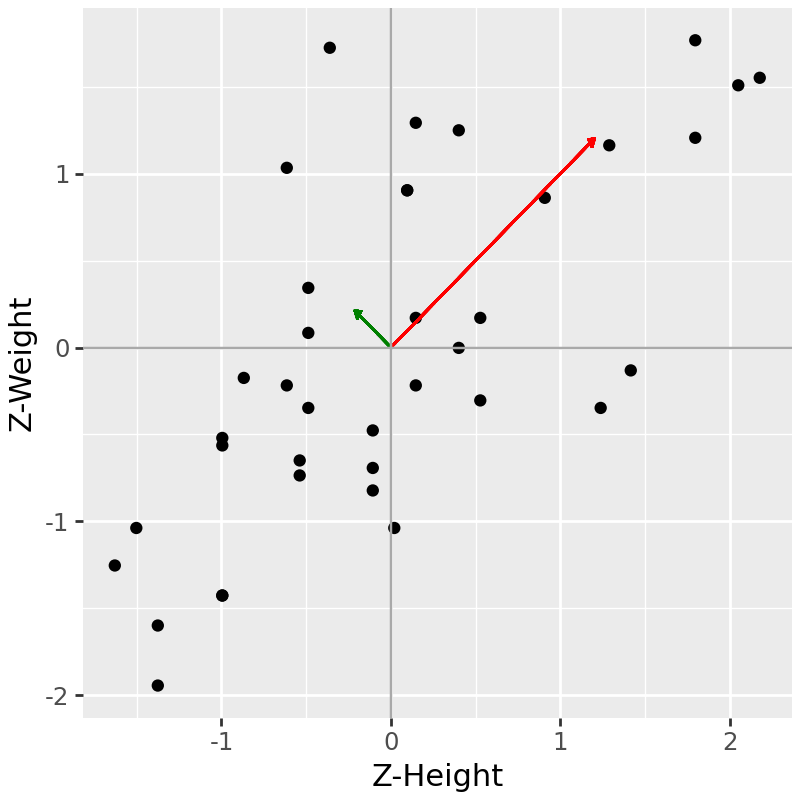

In [33]:
# (4th code cell)

# Create the scatter plot with Plotnine (z-score data)
gg = (
    p9.ggplot(data=df_DropNan, mapping=p9.aes(x='Z-Height', y='Z-Weight'))
    + p9.geom_point()
    + p9.theme(figure_size=(4, 4))

    + p9.geom_segment(
        x=0, y=0,
        xend=λ0*e0[0], yend=λ0*e0[1],
        color='red',
        arrow=p9.arrow(angle=30, length=0.05, ends="last", type="closed")
     )
    + p9.geom_segment(
        x=0, y=0,
        xend=λ1*e1[0], yend=λ1*e1[1],
        color='green',
        arrow=p9.arrow(angle=30, length=0.05, ends="last", type="closed")
     )
    + p9.geom_vline(xintercept=0, color='darkgrey')
    + p9.geom_hline(yintercept=0, color='darkgrey')
)

# Show plot
gg

<div class="alert alert-block alert-success"><b>
Practice 2 ends here.</b>
</div>

### The meaning of the covariance matrix

So far, given two z-scaled columns of our "Brain Size" dataset (`'Z-Height'` and `'Z-Weight'`), we have been able to compute the covariance matrix and to find its corresponding eigenvectors and eigenvalues . At the end of **Practice 2**, we intuitively verified a crucial insight about the covariance matrix: the **eigenvector with the largest eigenvalue** (in absolute value) is denoting the **direction along which our data exhibits the largest variability** contribution, and so on, the eigenvector with the second largest eigenvalue (in absolute value) is denoting the direction along which our data exhibits the second largest variability contribution. This is the key principle behind the [**Principal Component Analysis**](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA), a [dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction) technique of extreme utility in almost any data analysis scenario (if used correctly avoiding the typical error of over-interpretation). 
 
Having said that, now, let's organize the eigenvalues and eigenvectors of the z-scored covariance matrix `Sigma_Z` as nice list of `(eigenvalues, eigenvector)` tuples sorted in decreasing order according the absolute values of their corresponding eigenvalues:

In [119]:
# Make a nice list of (|eigenvalue|, eigenvector) tuples
eigentuples = [(np.abs(eigen.eigenvalues[i]), eigen.eigenvectors[:, i]) for i in range(len(eigen.eigenvalues))]

# Show the list of "eigentuples"
eigentuples

[(np.float64(1.699614004238759), array([0.70710678, 0.70710678])),
 (np.float64(0.3003859957612409), array([-0.70710678,  0.70710678]))]

In [120]:
# Sort the "eigentuples" from the highest to the lowest eigenvalue absolute value
eigentuples = sorted(eigentuples, reverse=True)

# Show the list of sorted "eigentuples"
eigentuples

[(np.float64(1.699614004238759), array([0.70710678, 0.70710678])),
 (np.float64(0.3003859957612409), array([-0.70710678,  0.70710678]))]

<div class="alert alert-block alert-info"><b>Tip:</b>
In our particular case, the tuples are already sorted, but we decided to "sort" them anyway so we don't loose any generality in our workflow.
</div>

### Dimensionality reduction

Ok, but what do we mean by *dimensionality reduction*? Our z-scaled data has two magnitudes (*features*), `Z-Height` and `Z-Weight` that have been tracked for multiple individuals (*samples*):

In [121]:
# Show our dataset
df_DropNan[['Z-Height', 'Z-Weight']].head()

,Z-Height,Z-Weight
1,-0.994966,-1.426680
3,1.238032,-0.347583
4,0.096158,0.904170
5,-0.868092,-0.174927
6,0.146908,-0.218091


In [122]:
# Get the number of samples and features in our dataset
n_samples, n_features = df_DropNan[['Z-Height', 'Z-Weight']].shape

# Print the number of samples and features in our dataset
print('Number of samples:', n_samples)
print('Number of features:', n_features)

Number of samples: 38
Number of features: 2


Therefore, our dataset has 38 points (samples) that lay on a bi-dimensional space (one dimension for each feature), so we can say that the dimensionality of our dataset is $(38 \times 2)$.

<div class="alert alert-block alert-info"><b>Tip:</b>
In a more general and typical case, the number of features is orders of magnitude higher than the number of samples. For example, a typical proteomics dataset has $\sim 10^{3}$ quantified proteins (features) across $\sim 10^{1}$ patients (samples), with a dataset dimensionality of $(\sim 10^{1} \times \sim 10^{3})$.
</div>

Let's collapse the dimensions of our dataset into a lower-dimensionality space, the [basis](https://www.google.com/search?client=firefox-b-d&q=base+of+a+linear+space) of which comprises the eigenvectors of the covariance matrix. In order to do that, we first need to prepare the projection matrix:

\begin{equation}
 \begin{pmatrix} \vec{e}_1 & \vec{e}_2 \end{pmatrix} =
 \begin{pmatrix} \begin{pmatrix} e_{11} \\ e_{21} \end{pmatrix} & \begin{pmatrix} e_{12} \\ e_{22} \end{pmatrix} \end{pmatrix} =
 \begin{pmatrix} \begin{pmatrix} 0.7071 \\ 0.7071 \end{pmatrix} & \begin{pmatrix} -0.7071 \\ 0.7071 \end{pmatrix} \end{pmatrix} =
 \begin{pmatrix} 0.7071 & -0.7071 \\ 0.7071 & 0.7071 \end{pmatrix}
\end{equation}

In [145]:
# Prepare the projection matrix with all eigenvectors
W = np.transpose(np.array([eigenvector for (eigenvalue, eigenvector) in eigentuples]))

# Show the projection matrix
print(W)

# Show the shape of the projection matrix
print(W.shape)

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
(2, 2)


<div class="alert alert-block alert-danger">

<b>Caveat:</b> Remember, eigenvector <b><u>as columns</u></b> of the projection matrix, (not as rows!):

</div>

Finally, before performing the dimensionality reduction, usually we must decide how many dimensions should we keep, this means, how many eigenvectors of the projection matrix should we keep:

In [160]:
# Define number of top-k eigenvectors of the projection matrix to keep
k = 2

# Select top-k eigenvectors of the projection matrix
W_Projection = W[0:k]

# Perform the dimensionality reduction: (38 x 2) @ (2 x 2) = (38 x 2)
df_DropNan_Projection = df_DropNan[['Z-Height', 'Z-Weight']] @ W_Projection

# Show the shape of the projection matrix
print(df_DropNan_Projection.shape)

# Show the shape of the projection matrix
df_DropNan_Projection.head()

(38, 2)


,0,1
1,0.305267,-1.712362
3,1.121199,0.629643
4,-0.571351,0.707338
5,-0.490141,-0.737526
6,0.258093,-0.050334


In [86]:
X_proj['PC1'] = X_proj[0]
X_proj['PC2'] = X_proj[1]

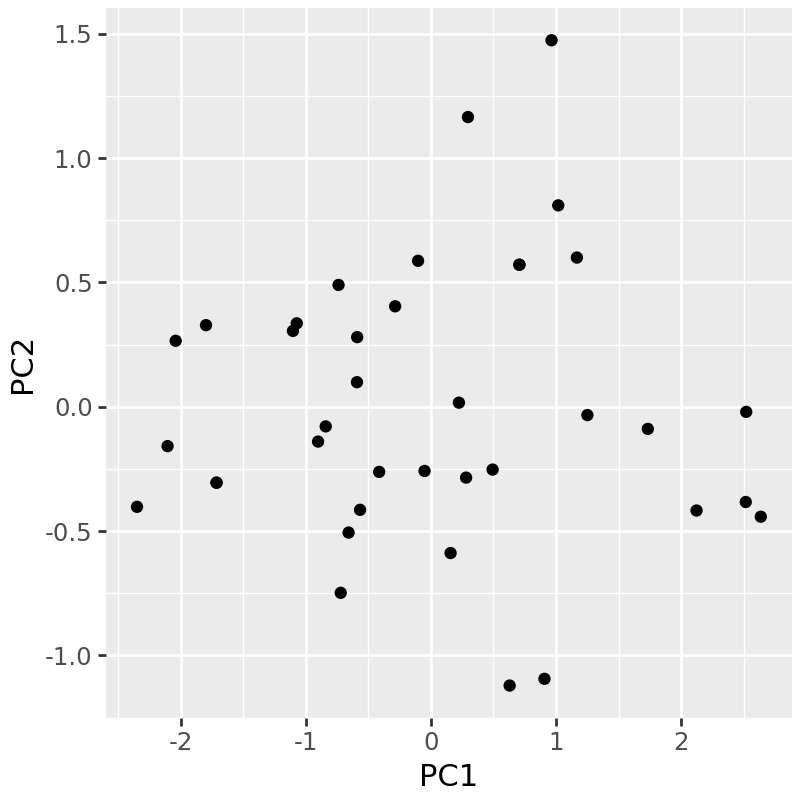

In [87]:
# Create the scatter plot with Plotnine (z-score data)
gg = (
    p9.ggplot(data=X_proj, mapping=p9.aes(x='PC1', y='PC2'))
    + p9.geom_point()
    + p9.theme(figure_size=(4, 4))
)

# Show plot
gg

In [83]:
eig_vals_total = sum(eig_vals_sorted)
explained_variance = [(i / eig_vals_total)*100 for i in eig_vals_sorted]
explained_variance = np.round(explained_variance, 2)
cum_explained_variance = np.cumsum(explained_variance)

print('Explained variance: {}'.format(explained_variance))
print('Cumulative explained variance: {}'.format(cum_explained_variance))

Explained variance: [84.98 15.02]
Cumulative explained variance: [ 84.98 100.  ]


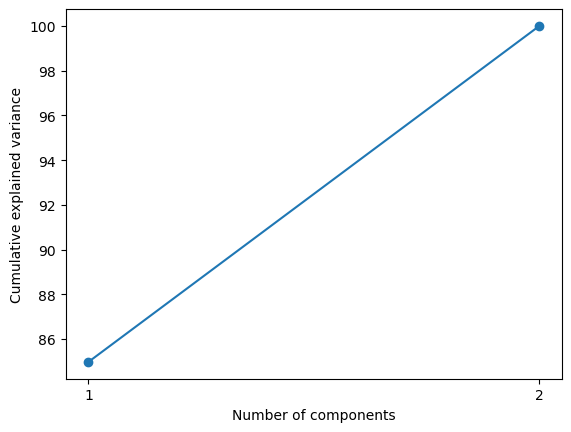

In [84]:
plt.plot(np.arange(1,n_features+1), cum_explained_variance, '-o')
plt.xticks(np.arange(1,n_features+1))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');
plt.show()

In [85]:
X_proj = df_DropNan[['Z-Height', 'Z-Weight']].dot(W.T)

print(X_proj.shape)

(38, 2)
